<a href="https://colab.research.google.com/github/David-gutierrez-rodriguez/Simulacion-I/blob/main/PG_Polinomios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 4.3 MB/s eta 0:00:00


   	      	                          fitness                          	                      size                     
   	      	-----------------------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max        	min    	nevals	std        	avg    	gen	max	min	nevals	std    
0  	300   	187071	0  	2.32354e+07	716.411	300   	1.60762e+06	7.09333	0  	15 	3  	300   	4.54803
1  	165   	12605.2	1  	160633     	726.047	165   	9103.08    	7.02   	1  	19 	1  	165   	4.39844
2  	153   	20149.2	2  	2.76255e+06	948.384	153   	158623     	7.25333	2  	21 	1  	153   	4.30687
3  	160   	34689.5	3  	6.79387e+06	948.384	160   	391120     	8.18667	3  	21 	1  	160   	4.69948
4  	169   	27321.3	4  	2.88756e+06	809.158	169   	188640     	8.97333	4  	25 	1  	169   	5.47716
5  	161   	19067.8	5  	1.14983e+06	486.103	161   	91489.8    	9.48667	5  	27 	1  	161   	5.89603
6  	166   	28888.2	6  	3.72181e+06	829.028	166   	219408     	11.16  	6  	27 	1  	166

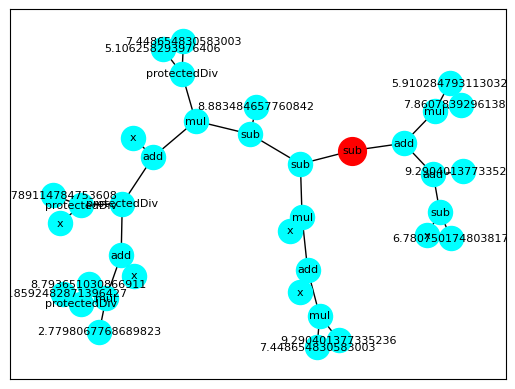

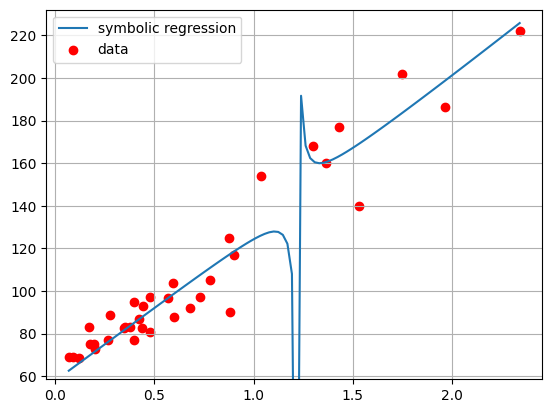

In [42]:
import operator
import math
import random

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

class txtParser:
    def __init__(self, txt):
        #Constructor
        self.x = []
        self.y = []
        self.populateList(txt)

    def populateList(self, file):
        with open(file) as fp:
            cnt = 0
            for line in fp:
                if(cnt<2):
                    cnt+=1
                    continue
                line = line.split()
                self.x.append(float(line[0]))
                self.y.append(float(line[1]))
        return #se puede comentar.

def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

def protectPow(base, power):
    try:
        return math.pow(base, power)
    except ValueError:
        return 1


def symbolicRegression(individual,toolbox, points, true):
    func = toolbox.compile(expr = individual)
    sqerrors = ((func(i)-j)**2 for i, j in zip(points, true))
    return math.fsum(sqerrors)/len(points),

def main():
    data = txtParser("regression4.txt")
    pset = gp.PrimitiveSet("main", 1)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(operator.add, 2)
    # pset.addPrimitive(math.cos, 1)
    # pset.addPrimitive(math.sin, 1)
    # pset.addPrimitive(math.tan, 1)
    # pset.addPrimitive(protectPow, 2)
    # pset.addPrimitive(np.exp, 1)
    pset.addPrimitive(protectedDiv, 2)
    pset.addEphemeralConstant("rand", lambda: np.random.uniform(-10,10))
    pset.renameArguments(ARG0='x')

    creator.create("FitnessMin", base.Fitness, weights=(-10.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)
    toolbox.register("evaluate",symbolicRegression,toolbox = toolbox, points = data.x, true = data.y)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=9))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=9))

    #seed = random.randint(1,10)
    seed = 1
    random.seed(seed)
    population = toolbox.population(n=300)
    halloffame = tools.HallOfFame(1)
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    pop, log = algorithms.eaSimple(population, toolbox, 0.5, 0.1, 40, stats=mstats,
                                   halloffame=halloffame, verbose=True)
    # print log
    # expr = halloffame[0]
    # tree = gp.PrimitiveTree(expr)
    # func = toolbox.compile(expr)
    # listres = []
    # print(str(tree))
    # for i in range(len(data.x)):
    #     listres.append("x: %2f" % data.x[i])
    #     listres.append("y: %2f" % func(data.x[i]))
    # i=0
    # j=0
    # SSE = 0.0
    # while i < len(listres):
    #     print("%s %s    Actual: %2f     Square error: %2f" %(listres[i],listres[i+1],data.y[j],(func(data.x[j])-data.y[j])**2))
    #     SSE+=(func(data.x[j])-data.y[j])**2
    #     j=j+1
    #     i=i+2
    # SSE/=len(data.x)
    # print("Seed: %d, Fitness: %2f"%(seed,SSE))


    best = halloffame.items[0]
    print("-- Best Individual = ", best)
    print("-- length={}, height={}".format(len(best), best.height))
    print("-- Best Fitness = ", best.fitness.values[0])


    nodes, edges, labels = gp.graph(best)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = nx.spring_layout(g)


    nx.draw_networkx_nodes(g, pos, node_color='cyan')
    nx.draw_networkx_nodes(g, pos, nodelist=[0], node_color='red',
    node_size=400)
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, **{"labels": labels,
    "font_size": 8})
    plt.show()

    func = toolbox.compile(expr = best)
    x = np.linspace(min(data.x), max(data.x), 100)
    y = [func(i) for i in x]
    plt.plot(x, y, label = "symbolic regression")
    plt.scatter(data.x, data.y, color = "red", label = "data")
    plt.ylim(min(data.y) - 10, max(data.y) + 10)
    plt.grid(True)
    plt.legend(loc = "best")
    plt.show()

    return

if __name__ == "__main__":
    main()